# Reinforcement Learning

# 2. Dynamic programming

This notebook presents policy iteration and value iteration for finding the optimal policy.

Note that these techniques require the enumeration of all states and thus apply to a few models only (e.g., walk, maze, Tic-Tac-Toe, Nim).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from tqdm.notebook import tqdm

from utils.model import Walk, Maze, TicTacToe, Nim
from utils.agent import Agent

%matplotlib inline

In [2]:
from IPython.core.display import display, HTML

def display_answer(title, answer):
    if isinstance(answer, list):
        string_display = f"""<div class="alert alert-block alert-success"> <h1>{title}:</h1><ul>"""
        for a in answer:
            string_display += f"<li>{a}</li>"
        string_display += "</ul></div>"
    elif isinstance(answer, str):
        string_display = f"""<div class="alert alert-block alert-success"> <h1>{title}:</h1>{answer} </div>"""
    else:
        raise ValueError("Answer should be a string or a list of strings.")
    display(HTML(string_display))

## Walk

In [3]:
walk = Walk()
states = walk.get_all_states()
print("Number of states : ", len(states))

Number of states :  25


## Maze

Number of states :  105


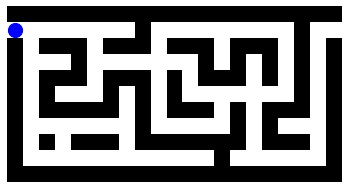

In [4]:
maze_map = np.load('utils/maze.npy')

maze = Maze()
init_state = (1, 0)
exit_state = (1, 20)
maze.set_parameters(maze_map, init_state, [exit_state])
maze = Maze()
states = maze.get_all_states()

print("Number of states : ", len(states))
maze.display()

## Policy Iteration

In policy iteration, you start from an arbitrary policy and improve it sequentially from its value function. The limiting policy is optimal.

In [5]:
from utils.dynamic import PolicyEvaluation, PolicyIteration

Number of values : 105


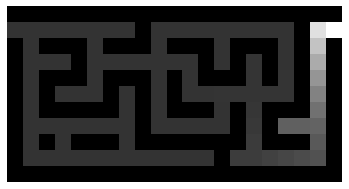

In [6]:
# let's start with the random policy
agent = Agent(maze)
policy = agent.policy

# policy evaluation
algo = PolicyEvaluation(maze, policy)
algo.evaluate_policy()
values = algo.values

print(f"Number of values : {len(values)}")
maze.display_values(values)

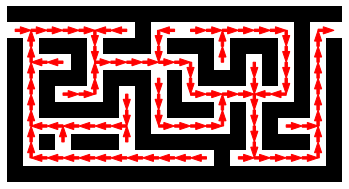

In [7]:
# policy improvement
new_policy = algo.get_policy()
maze.display_policy(new_policy)

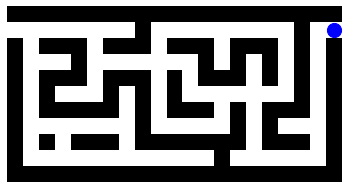

In [8]:
# let's test this new policy
agent = Agent(maze, new_policy)
stop, states, rewards = agent.get_episode()

animation = maze.display(states)
animation

In general, several iterations of policy evaluation / policy improvement are necessary. 

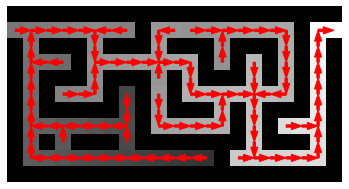

In [9]:
algo = PolicyIteration(maze)

policy = algo.get_optimal_policy()
maze.display_policy(policy)

values = algo.values
maze.display_values(values)

## To do

Consider the Walk environment with a discount factor $\gamma = 0.9$.
* What is the expected gain of a random walk?
* Compare with the expected gain of the optimal policy, obtained by Policy Iteration.
* Display the optimal value function and the optimal policy. Interpret the results.
* Increase the strength of the wind and observe the new results.

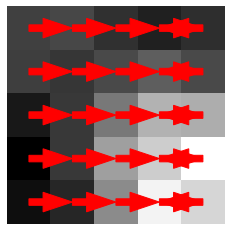

In [10]:
walk = Walk()
gamma = 0.9

agent = Agent(walk)

# random policy
policy = agent.policy
algo = PolicyEvaluation(walk, policy, gamma=gamma)
algo.evaluate_policy()
walk.display_policy(policy)

values = algo.values
walk.display_values(values)

gains = agent.get_gains(gamma=gamma)
display_answer("Answer", f"The expected gain of random walk is about {np.mean(gains):.2f}.")

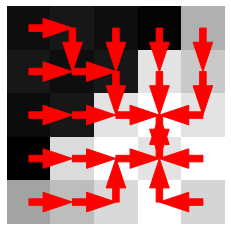

In [11]:
# optimal value function
algo_optimal = PolicyIteration(walk, gamma=gamma)

policy_optimal = algo_optimal.get_optimal_policy()
walk.display_policy(policy_optimal)

values_optimal = algo_optimal.values
walk.display_values(values_optimal)

agent_optimal = Agent(walk, policy_optimal)
gains_optimal = agent_optimal.get_gains(gamma=gamma)
string_answer = [
    f"<b>Gain:</b> The expected gain of the optimal policy is about {np.mean(gains_optimal):.2f}.",
    "<b>Interpretation:</b> The optimal policy is to go right at each step. The value function is the expected gain from each state."
]
display_answer("Answer", string_answer)

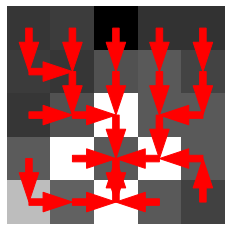

In [12]:
# previous wind 
previous_wind = walk.Wind

# new wind
new_wind = {(0, 1): 0.8, (1, 0): 0.1}

Walk.set_parameters(Walk.Size, Walk.Rewards, new_wind)

walk_new_wind = Walk()
algo_optimal_new_wind = PolicyIteration(walk_new_wind, gamma=gamma)
policy_optimal_new_wind = algo_optimal_new_wind.get_optimal_policy()
walk.display_policy(policy_optimal_new_wind)

values_optimal_new_wind = algo_optimal_new_wind.values
walk.display_values(values_optimal_new_wind)

agent_optimal_new_wind = Agent(walk, policy_optimal_new_wind)
gains_optimal_new_wind = agent_optimal_new_wind.get_gains(gamma=gamma)

display_answer("New Wind", f"The expected gain of the optimal policy with the new wind is about {np.mean(gains_optimal):.2f}.")

## Value Iteration

Value iteration relies on Bellman's optimality equation. 

## To do

Check the code of ``ValueIteration`` below.
* Complete the method ``get_optimal_policy``.
* Test it on the maze and the walk.
* You play TicTacToe at random against an adversary using the one-step policy. What is your expected gain? 
* Observe the improvement when you play perfectly against the same adversary.
* Do the same with Nim.

In [13]:
class ValueIteration(PolicyEvaluation):
    """Value iteration. 
    
    Parameters
    ----------
    model: object of class Environment
        The model.
    player: int
        Player for games (1 or -1, default = default player of the game).        
    gamma: float
        Discount factor (between 0 and 1).
    n_iter: int
        Maximum number of value iterations.
    """
    
    def __init__(self, model, player=None, gamma=1, n_iter=100):
        agent = Agent(model, player=player)
        policy = agent.policy
        player = agent.player
        super(ValueIteration, self).__init__(model, policy, player, gamma)  
        self.n_iter = n_iter
        
    def get_optimal_policy(self):
        """Get the optimal policy by iteration of Bellman's optimality equation."""
        transitions = self.transitions
        # Bellman's optimality equation
        values = np.zeros(self.n_states)
        for t in range(self.n_iter):
            next_values = self.rewards + self.gamma * values
            action_value = {action: transition.dot(next_values) for action, transition in self.transitions.items()}
            values = np.zeros(self.n_states)
            for i, state in enumerate(self.states):
                if not self.model.is_terminal(state):
                    actions = self.get_actions(state)
                    # update values
                    values[i] = max(action_value[action][i] for action in actions)
        self.values = values
        policy = self.get_policy()
        return policy


### Test on Walk and Maze

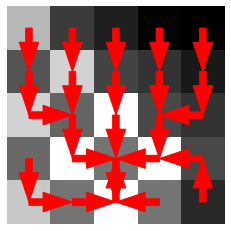

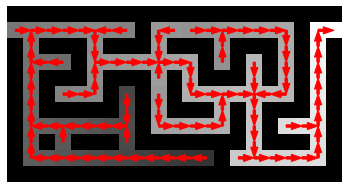

In [14]:
for model, name in zip([Walk(), Maze()], ["Walk", "Maze"]):
    algo = ValueIteration(model)

    policy = algo.get_optimal_policy()
    model.display_policy(policy)

    values = algo.values
    model.display_values(values)

    plt.show()

    agent = Agent(model, policy)
    gains = agent.get_gains()

    display_answer(name, f"The expected gain of the value iteration policy is about {np.mean(gains):.2f}.")

### Games

In [15]:
def play_games(game, player_policy, adversary_policy, n_games=1000):

    player_policy_name = player_policy
    adversary_policy_name = adversary_policy
    if player_policy == 'random':
        agent_player = Agent(game, player=1)
    elif player_policy == 'one_step':
        agent_player = Agent(game, player=1, policy='one_step')
    elif player_policy == 'perfect':
        algo = ValueIteration(game)
        player_policy = algo.get_optimal_policy()
        agent_player = Agent(game, player=1, policy=player_policy)
    else:
        raise ValueError("Policy should be 'random', 'one_step' or 'perfect'.")

    if adversary_policy == 'random':
        agent_adversary = Agent(game, player=-1)
    elif adversary_policy == 'one_step':
        agent_adversary = Agent(game, player=-1, policy='one_step')
    elif adversary_policy == 'perfect':
        algo = ValueIteration(game)
        adversary_policy = algo.get_optimal_policy()
        agent_adversary = Agent(game, player=-1, policy=adversary_policy)
    else:
        raise ValueError("Policy should be 'random', 'one_step' or 'perfect'.")

    gains = []

    for _ in tqdm(range(n_games), desc=f"Simulating games with {player_policy_name} player and {adversary_policy_name} adversary"):
        game.reset()
        while not game.is_terminal(game.state):
            if game.state[0] == game.player:
                action = agent_player.get_action(game.state)
            else:
                action = agent_adversary.get_action(game.state)
            game.state = game.get_next_state(game.state, action)
        gains.append(game.get_reward(game.state))

    return np.mean(gains)

In [16]:
for name, game in zip(["Tic-Tac-Toe", "Nim"], [TicTacToe(), Nim()]):
    random_gain = play_games(game, 'random', 'one_step')
    perfect_gain = play_games(game, 'perfect', 'one_step')
    display_answer(name, [
        f"<b>Random Policy:</b> The expected gain of the random policy versus a one-step player is about {random_gain:.2f}.",
        f"<b>Perfect Policy:</b> The expected gain of the perfect policy versus a one-step player is about {perfect_gain:.2f}."
    ])

Simulating games with random player and one_step adversary:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating games with perfect player and one_step adversary:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating games with random player and one_step adversary:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating games with perfect player and one_step adversary:   0%|          | 0/1000 [00:00<?, ?it/s]

## Perfect players

We now use Value Iteration to get perfect players, assuming the best response of the adversary.

## To do

Check the code of the new class ``ValueIteration`` below.
* Complete the method ``get_perfect_players``.
* Test it on TicTacToe. Who wins?
* Test it on Nim. Who wins?
* Is this approach applicable to ConnectFour? Why?

In [17]:
class ValueIteration(PolicyEvaluation):
    """Value iteration. 
    
    Parameters
    ----------
    model: object of class Environment
        The model.
    player: int
        Player for games (1 or -1, default = default player of the game).        
    gamma: float
        Discount factor (between 0 and 1).
    n_iter: int
        Maximum number of value iterations.
    """
    
    def __init__(self, model, player=None, gamma=1, n_iter=100):
        agent = Agent(model, player=player)
        policy = agent.policy
        player = agent.player
        super(ValueIteration, self).__init__(model, policy, player, gamma)  
        self.n_iter = n_iter
    
    def get_perfect_players(self):
        """Get perfect players for games, with the best response of the adversary."""
        if not self.model.is_game():
            raise ValueError("This method applies to games only.")
        # get transitions for each player
        actions = self.model.get_all_actions()
        transitions = {action: sparse.lil_matrix((self.n_states, self.n_states)) for action in actions}
        for i, state in enumerate(self.states):    
            actions = self.model.get_available_actions(state)
            for action in actions:
                next_state = self.model.get_next_state(state, action)
                j = self.get_state_id(next_state)
                transitions[action][i, j] = 1
        transitions = {action: sparse.csr_matrix(transition) for action, transition in transitions.items()}
        self.transitions = transitions
        # Bellman's optimality equation
        values = np.zeros(self.n_states)
        # to be completed
        for _ in range(self.n_iter):
            next_values = self.rewards + self.gamma * values
            action_value = {action: transition.dot(next_values) for action, transition in self.transitions.items()}
            for i, state in enumerate(self.states):
                if not self.model.is_terminal(state):
                    current_player, _ = state
                    actions = self.get_actions(state, player=current_player)
                    # update values
                    if current_player == self.player:
                        values[i] = max(action_value[action][i] for action in actions)
                    else:
                        values[i] = min(action_value[action][i] for action in actions)

        self.values = values
        # policies
        policy = self.get_policy(self.player)
        adversary_policy = self.get_policy(-self.player)
        return policy, adversary_policy
        

In [19]:
for name, Game in zip(["Tic-Tac-Toe", "Nim"], [TicTacToe, Nim]):

    game = Game()
    algo = ValueIteration(game)
    policy, adversary_policy = algo.get_perfect_players()

    game = Game(adversary_policy=adversary_policy)
    agent_player = Agent(game, player=1, policy=policy)

    gains = []
    for _ in tqdm(range(1000), desc="Simulating games"):
        game.reset()
        while not game.is_terminal(game.state):
            if game.state[0] == 1:
                action = agent_player.get_action(game.state)
            else:
                action = game.adversary.get_action(game.state)
            game.state = game.get_next_state(game.state, action)

        gains.append(game.get_reward(game.state))

    display_answer(name, f"The expected gain for perfect players is about {np.mean(gains):.2f} for the player starting the game. It seems that with perfect players, {name} {'is a draw game' if np.mean(gains) == 0. else ''}{'favors the first one to play' if np.mean(gains) > 0 else ''}{'favors the second one to play' if np.mean(gains) < 0. else ''}.")

answer_connect4 = [
    "<b>State Space Size</b>: ConnectFour has a very large state space. The number of possible board configurations is extremely high, making it impractical to enumerate all states and transitions.",
    "<b>Time Complexity</b>: The time required to converge to an optimal policy using dynamic programming methods like value iteration or policy iteration would be excessively long due to the vast number of states and actions.",
    "In summary, the large state space and high computational complexity make dynamic programming approaches like value iteration and policy iteration impractical for ConnectFour."
]
display_answer("Connect-Four", answer_connect4)


Simulating games:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulating games:   0%|          | 0/1000 [00:00<?, ?it/s]